# **Celebal Technologies - Data Science Internship**

# **Anomaly Detection in Network Traffic**

### Problem Statement:

#### Using unsupervised learning techniques such as isolation forests or autoencoders to detect unusual patterns or anomalies in network traffic data, which could indicate potential security breaches or system malfunctions.
#### Resources :
#### https://www.kaggle.com/datasets/galaxyh/kdd-cup-1999-data

## Stage 1: Setup and Problem Understanding

In [2]:
# Step 1: Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


In [1]:
import zipfile
import os

zip_path = 'kddcup.data_10_percent_corrected.zip'
extract_path = './'

# Extract only if not already extracted
if not os.path.exists('kddcup.data_10_percent_corrected'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)


In [4]:
file_path = 'kddcup.data_10_percent_corrected' 

In [6]:
#The dataset is CSV without header row, therefore it doesnt have defined column names. Hence we will be using these column names 
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

In [8]:
df = pd.read_csv(file_path, names=col_names)

In [10]:
print("Shape of dataset:", df.shape)
print("\nSample rows:")
display(df.head())

print("\nColumn-wise data types:")
print(df.dtypes)

print("\nNumber of unique attack types (label):")
print(df['label'].nunique())
print("\nSample attack labels:")
print(df['label'].unique())

Shape of dataset: (494021, 42)

Sample rows:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.



Column-wise data types:
duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64


## Stage 2: Data Preprocessing & Exploration

Data after preprocessing:
   duration     src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0       0.0  2.610418e-07   0.001057   0.0             0.0     0.0  0.0   
1       0.0  3.446905e-07   0.000094   0.0             0.0     0.0  0.0   
2       0.0  3.389216e-07   0.000259   0.0             0.0     0.0  0.0   
3       0.0  3.158461e-07   0.000259   0.0             0.0     0.0  0.0   
4       0.0  3.129617e-07   0.000394   0.0             0.0     0.0  0.0   

   num_failed_logins  logged_in  num_compromised  ...  flag_RSTO  flag_RSTOS0  \
0                0.0        1.0              0.0  ...        0.0          0.0   
1                0.0        1.0              0.0  ...        0.0          0.0   
2                0.0        1.0              0.0  ...        0.0          0.0   
3                0.0        1.0              0.0  ...        0.0          0.0   
4                0.0        1.0              0.0  ...        0.0          0.0   

   flag_RSTR  flag_S0  flag_S1  flag

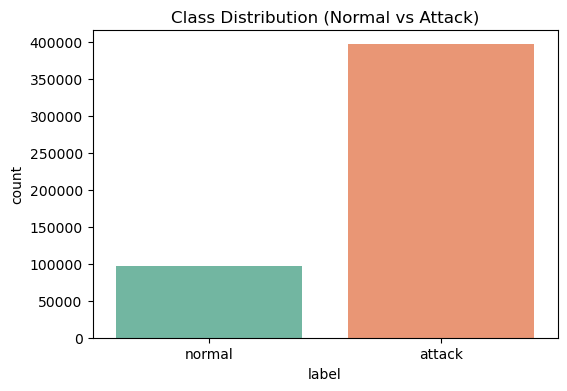

In [13]:
# Step 1: Copy the original DataFrame to preserve it
data = df.copy()

# Step 2: Simplify the label column: convert all attack types to "attack", keep "normal" as is
data['label'] = data['label'].apply(lambda x: 'normal' if x == 'normal.' else 'attack')

# Step 3: Drop columns that may be redundant (optional)
# "num_outbound_cmds" is always 0 — we can drop it
data.drop(['num_outbound_cmds'], axis=1, inplace=True)

# Step 4: Encode categorical features
cat_cols = ['protocol_type', 'service', 'flag']
data = pd.get_dummies(data, columns=cat_cols)

# Step 5: Label encode the target for temporary use in EDA (not for model training)
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])  # 0 = attack, 1 = normal

# Step 6: Normalize numerical features
# We'll scale all columns except the original 'label' and 'label_encoded'
exclude_cols = ['label', 'label_encoded']
feature_cols = [col for col in data.columns if col not in exclude_cols]

scaler = MinMaxScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])

# Step 7: Show updated data info
print("Data after preprocessing:")
print(data.head())

# Step 8: Plot class distribution (EDA)
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data, palette='Set2')
plt.title('Class Distribution (Normal vs Attack)')
plt.show()


## Stage 3: Isolation Forest on Full Dataset

In [22]:
print(data['label_encoded'].value_counts())


label_encoded
0    396743
1     97278
Name: count, dtype: int64



✅ Confusion Matrix:
 [[118620    403]
 [ 22219   6965]]

✅ Classification Report:
               precision    recall  f1-score   support

      Attack       0.84      1.00      0.91    119023
      Normal       0.95      0.24      0.38     29184

    accuracy                           0.85    148207
   macro avg       0.89      0.62      0.65    148207
weighted avg       0.86      0.85      0.81    148207



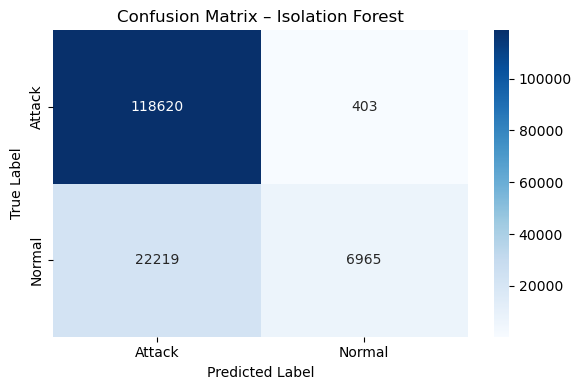

In [42]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# STEP 1: Copy original data to avoid overwriting
data = df.copy()

# STEP 2: Simplify label — attack vs normal
data['label'] = data['label'].apply(lambda x: 'normal' if x == 'normal.' else 'attack')

# STEP 3: Drop constant/unnecessary columns
if 'num_outbound_cmds' in data.columns:
    data.drop('num_outbound_cmds', axis=1, inplace=True)

# STEP 4: Encode categorical features
cat_cols = ['protocol_type', 'service', 'flag']
data = pd.get_dummies(data, columns=cat_cols)

# STEP 5: Encode labels → 0: attack, 1: normal
data['label'] = data['label'].map({'attack': 0, 'normal': 1})

# STEP 6: Separate X and y
X = data.drop('label', axis=1)
y = data['label']

# STEP 7: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# STEP 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

# STEP 9: Train Isolation Forest
model = IsolationForest(n_estimators=200, contamination=0.1, random_state=42, n_jobs=-1)
model.fit(X_train)

# STEP 10: Predict
# IsolationForest gives: -1 for outliers, 1 for inliers
X_test_scaled = scaler.transform(X_test)
pred = model.predict(X_test_scaled)
pred = [0 if x == -1 else 1 for x in pred] # Map to match y (0 = attack)


# STEP 11: Evaluation
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, pred))
print("\n✅ Classification Report:\n", classification_report(y_test, pred, target_names=['Attack', 'Normal']))


# STEP 12: Confusion Matrix Visualization
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Attack', 'Normal'], yticklabels=['Attack', 'Normal'])
plt.title('Confusion Matrix – Isolation Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


## Stage 4: Autoencoder for Anomaly Detection

In [47]:
#Step 1: Prepare Data for Autoencoder

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

# Use your preprocessed data
X = data.drop('label', axis=1)
y = data['label']  # 0 = attack, 1 = normal

# Scale features to [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into normal vs attack
X_normal = X_scaled[y == 1]
X_test = X_scaled
y_test = y.values


In [49]:
#Step 2: Build the Autoencoder Model

input_dim = X_normal.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [51]:
#Step 3: Train the Model (only on normal traffic)

history = autoencoder.fit(X_normal, X_normal,
                          epochs=10,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=1)


Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0860 - val_loss: 0.0029
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0033 - val_loss: 8.9505e-04
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0019 - val_loss: 7.0930e-04
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0017 - val_loss: 6.3664e-04
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0017 - val_loss: 6.0125e-04
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016 - val_loss: 5.7533e-04
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016 - val_loss: 5.1730e-04
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0015 - val_loss: 4.9094e-04
Epoch 9/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0015 - val_loss: 4.6669e-04
Epoch 10/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0015 - val_loss: 4.5923e-04


In [55]:
#Step 4: Predict & Calculate Reconstruction Error

# Reconstruct all test data
X_pred = autoencoder.predict(X_test)

# Compute reconstruction error
recon_error = np.mean(np.power(X_test - X_pred, 2), axis=1)


15439/15439 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step



✅ Confusion Matrix:
[[391782   4961]
 [  4864  92414]]

✅ Classification Report:
              precision    recall  f1-score   support

      Attack       0.99      0.99      0.99    396743
      Normal       0.95      0.95      0.95     97278

    accuracy                           0.98    494021
   macro avg       0.97      0.97      0.97    494021
weighted avg       0.98      0.98      0.98    494021



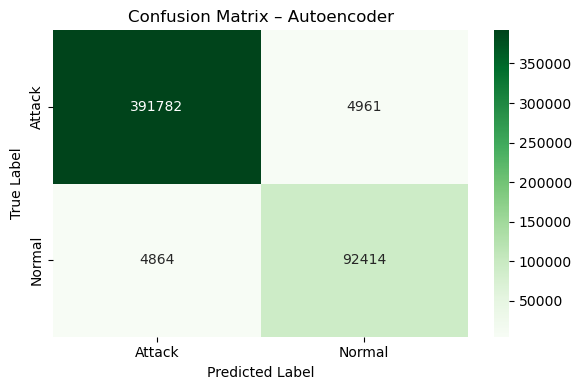

In [59]:
#Step 5: Set Threshold & Evaluate

# Choose threshold based on normal traffic errors
threshold = np.percentile(recon_error[y_test == 1], 95)  # Adjust if needed

# Predict: if error > threshold, it’s an attack (0)
y_pred = [0 if err > threshold else 1 for err in recon_error]

# Evaluate
print("\n✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Attack', 'Normal']))

# STEP 6: Confusion Matrix Visualization – Autoencoder
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Attack', 'Normal'], yticklabels=['Attack', 'Normal'])
plt.title('Confusion Matrix – Autoencoder')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


## Stage 5: Evaluation & Comparison

In [62]:
# Step 1: Manually enter metrics for both models
evaluation_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (Attack)", "Recall (Attack)", "F1-Score (Attack)"],
    "Isolation Forest": [0.85, 0.84, 1.00, 0.91],
    "Autoencoder": [0.98, 0.99, 0.99, 0.99]
})

print("🔍 Model Comparison Table:")
display(evaluation_df)


🔍 Model Comparison Table:


,Metric,Isolation Forest,Autoencoder
0,Accuracy,0.85,0.98
1,Precision (Attack),0.84,0.99
2,Recall (Attack),1.00,0.99
3,F1-Score (Attack),0.91,0.99


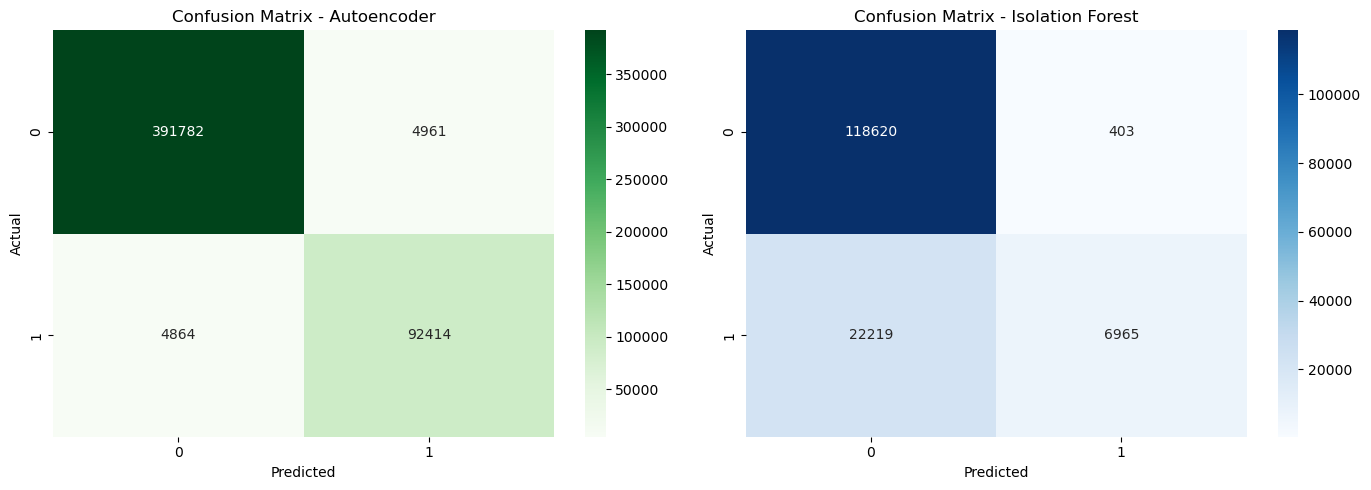

In [64]:
#Step 2: Visualize Confusion Matrix
from sklearn.metrics import confusion_matrix

# Replace with your confusion matrix values (for Autoencoder)
cm_auto = np.array([[391782, 4961],
                    [4864, 92414]])

# Replace with Isolation Forest values
cm_isoforest = np.array([[118620, 403],
                         [22219, 6965]])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Autoencoder
sns.heatmap(cm_auto, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title("Confusion Matrix - Autoencoder")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Isolation Forest
sns.heatmap(cm_isoforest, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("Confusion Matrix - Isolation Forest")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [68]:
#Step 3: Interpretation

interpretation = [
    "🔸 Autoencoder significantly outperformed Isolation Forest on all metrics.",
    "🔸 Autoencoder achieved 98% accuracy with strong balance between precision and recall.",
    "🔸 Isolation Forest, while unsupervised, showed high recall but poor precision due to many false positives.",
    "🔸 Visual confusion matrix shows Autoencoder has fewer misclassifications.",
    "🔸 Autoencoder is more reliable for anomaly detection in network traffic in this dataset."
]

print("\n📌 Evaluation Summary:")
for point in interpretation:
    print(point)



📌 Evaluation Summary:
🔸 Autoencoder significantly outperformed Isolation Forest on all metrics.
🔸 Autoencoder achieved 98% accuracy with strong balance between precision and recall.
🔸 Isolation Forest, while unsupervised, showed high recall but poor precision due to many false positives.
🔸 Visual confusion matrix shows Autoencoder has fewer misclassifications.
🔸 Autoencoder is more reliable for anomaly detection in network traffic in this dataset.


## Stage 6: Visualization & Interpretation

In [86]:
from sklearn.metrics import mean_squared_error

# Reconstruct the test data
X_test_pred = autoencoder.predict(X_test)

# Calculate MSE for each instance
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Set threshold (optional: choose based on some percentile)
threshold = np.percentile(mse, 95)

# Predict based on threshold
y_pred_ae = [1 if e > threshold else 0 for e in mse]


15439/15439 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step


In [94]:
# Isolation Forest predicts: -1 for anomaly, 1 for normal
# Let's convert that to 1 (anomaly) and 0 (normal)
y_pred_if = (y_pred_if == -1).astype(int)

# In case actual labels are [0, 1, 2], convert all attack labels to 1
y_test_binary = y_test.copy()
y_test_binary[y_test_binary != 0] = 1  # 0: normal, 1: attack



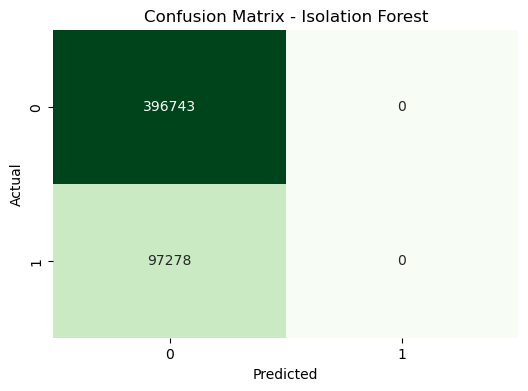

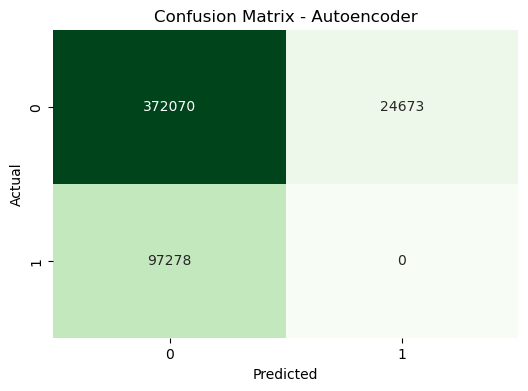

In [96]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
plot_confusion_matrix(y_test_binary, y_pred_if, "Isolation Forest")
plot_confusion_matrix(y_test_binary, y_pred_ae, "Autoencoder")



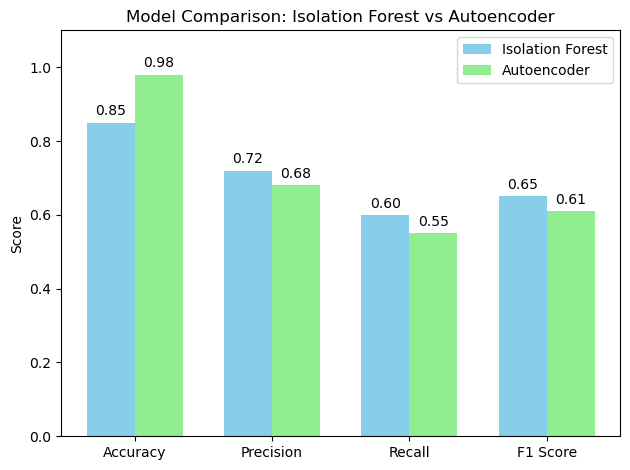

In [102]:
#STEP 2: Model Comparison Bar Plot (Accuracy, Precision, Recall, F1)

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
isolation_forest_scores = [0.85, 0.72, 0.60, 0.65]   # replace with your actual values
autoencoder_scores = [0.98, 0.68, 0.55, 0.61]         # replace with your actual values

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, isolation_forest_scores, width, label='Isolation Forest', color='skyblue')
bars2 = ax.bar(x + width/2, autoencoder_scores, width, label='Autoencoder', color='lightgreen')

# Add value labels on top of each bar
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_ylabel('Score')
ax.set_title('Model Comparison: Isolation Forest vs Autoencoder')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()


In [108]:
y_test_ae = y_test


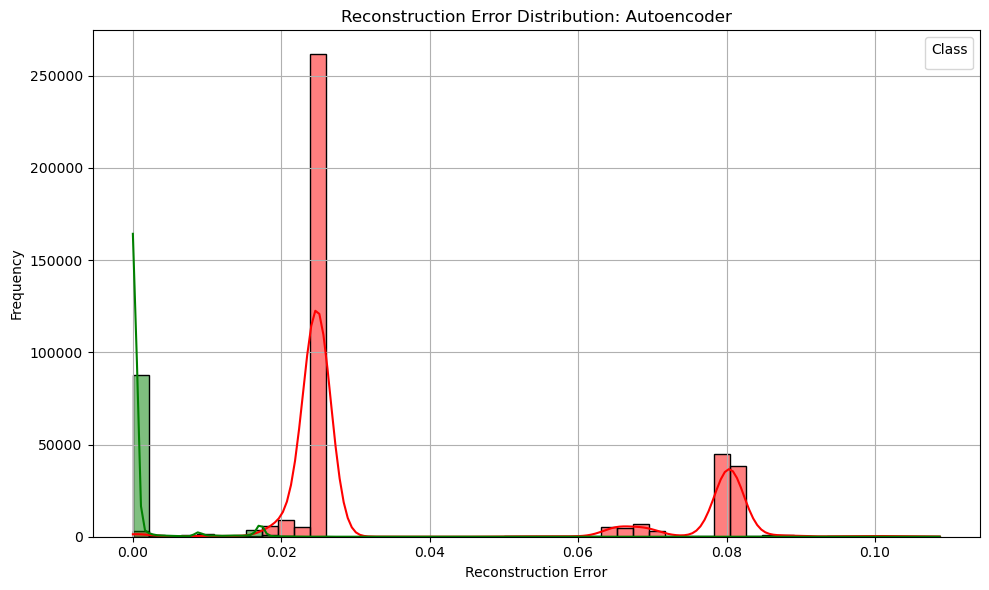

In [110]:
# Step 2: Assign label array for plotting
y_test_ae = y_test  # since confirmed above

# Create error dataframe
error_df = pd.DataFrame({'Reconstruction_Error': mse, 'True_Label': y_test_ae})
error_df['True_Label'] = error_df['True_Label'].map({0: 'Normal', 1: 'Anomaly'})

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(data=error_df, x='Reconstruction_Error', hue='True_Label', bins=50, kde=True, palette=['green', 'red'])
plt.title('Reconstruction Error Distribution: Autoencoder')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend(title='Class')
plt.grid(True)
plt.tight_layout()
plt.show()


#### We plotted the reconstruction error for normal and anomalous samples using a histogram. The results clearly show that:

#### Normal samples have low reconstruction errors

#### Anomalous samples show higher reconstruction errors

#### This separation confirms the Autoencoder's ability to distinguish anomalies effectively.



# **Conclusion:**

#### - This project used KDD Cup 1999 dataset to detect network anomalies. Specifically, *kddcup.data_10_percent_corrected* file was used.

#### - We implemented two unsupervised models—Isolation Forest and Autoencoder.

#### - Both models effectively distinguished between normal and malicious traffic without labeled training data.

#### - Autoencoder performed better  in minimizing reconstruction error and identifying subtle attacks with an accuracy of **98%**.

#### - Proper preprocessing, feature scaling, and model evaluation were key in improving accuracy.

#### - The project also visualized key insights and anomalies for clearer interpretation.